In [3]:

import numpy as np

for p in range(1, t):
    
    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1], dtype=int)  # empty matrix
    
    # calculate the "safety effect" for a particular bank
    which_safe = np.where(banks['income'][p-1,] < 0, safety_effect, 0)
    
    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p,] = households['which_bank'][p-1,].copy()
    for u in range(n_households):
        withdrawal_prob_new = households['withdrawal_prob'][0, u] + which_safe[int(households['which_bank'][p, u])-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], size=1, p=[withdrawal_prob_new, 1-withdrawal_prob_new])[0]
    
    # randomly generating new bank for each deposit to change (household can change bank to the same bank. IK its weird tho)
    change_indices = np.where(bank_change == 1)[0]
    if len(change_indices) > 0:
        new_banks = np.random.choice(np.where(banks['bankruptcy'][p-1,] == 0)[0], size=len(change_indices), replace=True)
        households['which_bank'][p, change_indices] = new_banks
    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p,] = borrowers['loan_value'][p-1,].copy()
    which_default = np.zeros(borrowers['loan_value'].shape[1], dtype=int)  # empty matrix
    
    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    default_indices = np.where(borrowers['loan_value'][p,] == 1)[0]
    for i in default_indices:
        which_default[i] = np.random.choice([1, 0], size=1, p=[borrowers['pd'][p, i], 1-borrowers['pd'][p, i]])[0]
        # Defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0
    
    # Write-off loan defaults
    with_write_off = borrowers['loan_value'][p,].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate
    
    # Calculating credit loss
    borrowers['which_bank'][p,] = borrowers['which_bank'][p-1,]
    # Import necessary libraries
    # Assuming p is the current period and other variables are defined appropriately
    
    # Calculate loan portfolio for non-bankrupt banks
    for r in np.where(banks['bankruptcy'][p-1,] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p,] == r)[0]])
    
    # Calculate loan loss
    loan_loss_t = banks['loan_portfolio'][p,] - banks['loan_portfolio'][p-1,]
    
    # Update expected loss provisions
    borrowers['recovery_rate'][p,] = borrowers['recovery_rate'][p-1,]
    for a in np.where(banks['bankruptcy'][p-1,] == 0)[0]:
        banks['exp_loss_provision'][p, a] = np.sum(borrowers['pd'][p, np.where(borrowers['which_bank'][p,] == a)[0]] * 
                                                   borrowers['loan_value'][p, np.where(borrowers['which_bank'][p,] == a)[0]] * 
                                                   (1 - borrowers['recovery_rate'][p, np.where(borrowers['which_bank'][p,] == a)[0]]))
        
        
    # Update reserves
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # Determine which banks need to sell loans due to not meeting the minimal reserve requirements
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # Empty array for further PnL calculation
    
    # Loop through banks that do not meet the reserve requirements
    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
    
        # Minimal number of loans to sell
        min_nr_loans_sell = np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell).astype(int)
        
        # Calculate fire sell loss for further PnL calculation
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)
        
        # Retrieve loans from borrowers
        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        num_loans_to_sell = min(min_nr_loans_sell, len(bank_loans))
        
        if num_loans_to_sell > 0:
            borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
                [np.ones(len(bank_loans) - num_loans_to_sell, dtype=int), np.zeros(num_loans_to_sell, dtype=int)]
            )


    #banks$reserves[p,] <- banks$sum_deposits[p,] - banks$loan_portfolio[p,] + banks$equity[p-1,] 
    ##banks['reserves'][p,:] = banks['sum_deposits'][p,:] - banks['loan_portfolio'][p,:] + banks['equity'][p-1]
     
        # Repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
    
    ########### Calculating PnL and Balance Sheet ###############
    
    # Changing spread (i.e., profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p])) / n_banks)
    
    ## Revenue of the bank
    # Interest revenue
    
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) / (1 - borrowers['pd'][2, l]))
        #basic formula for loan margin etc etc.
    # Assuming necessary variables and arrays are already defined
    
    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # Cost of capital multiplied by loan value
        revenue_loop = (np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) -
                        np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]))  # minus length because we use a formula 1+interest 
        # Adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += (banks['reserves'][p-1, y] * interest[p-1])
        
        banks['revenue'][p, y] = revenue_loop
    
    # Costs of the bank
    # Deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = (np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) +
                               fire_sell_loss[f])
    
    # Liquidity assistance cost
    banks['cost'][p, :] += (banks['liquidity_assistance'][p-1, :] * interest[p])
    
    
    # Assuming necessary variables and arrays are already defined

    # Banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]
    '''
    # Dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # A bank may give a dividend if the equity exceeds the capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)
    
        # Second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))
    
        # If one of them doesn't allow dividends (i.e., 0) then give zero
        banks['dividends'][p, g] = np.min(np.maximum([max_dividend, max_dividend_by_deposits], 0))
        banks['equity'][p, g] -= np.min(np.maximum([max_dividend, max_dividend_by_deposits], 0))
    
     '''   
                   


#%%


import numpy as np

for p in range(1, t):

    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u] + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0]
        if len(change_indices) > 0:
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks

    # change of the total deposits
    households['depo_value'][p, :] = households['depo_value'][p-1, :]
    for e in non_bankrupt_banks:
        banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, np.where(households['which_bank'][p, :] == e)[0]])

    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p, :] = borrowers['loan_value'][p-1, :]
    which_default = np.zeros(borrowers['loan_value'].shape[1])  # empty array

    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    for i in np.where(borrowers['loan_value'][p, :] == 1)[0]:
        which_default[i] = np.random.choice([1, 0], p=[borrowers['pd'][p, i], 1 - borrowers['pd'][p, i]])

    # defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0

    # write-off loan defaults
    with_write_off = borrowers['loan_value'][p, :].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate

    # calculating credit loss
    borrowers['which_bank'][p, :] = borrowers['which_bank'][p-1, :]
    for r in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p, :] == r)[0]])

    loan_loss_t = banks['loan_portfolio'][p, :] - banks['loan_portfolio'][p-1, :]

    # updating expected loss provisions
    borrowers['recovery_rate'][p, :] = borrowers['recovery_rate'][p-1, :]
    for a in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        indices = np.where(borrowers['which_bank'][p, :] == a)[0]
        banks['exp_loss_provision'][p, a] = np.sum(
            borrowers['pd'][p, indices] * borrowers['loan_value'][p, indices] * (1 - borrowers['recovery_rate'][p, indices])
        )

    ############ reserve check ##########
    # adjusting reserves to change in deposits
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # which bank must sell loans because of the minimal reserves (1 if they fulfill the requirements, 0 otherwise)
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # empty array for further PnL calculation

    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
        min_nr_loans_sell = int(np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell))
        min_nr_loans_sell = min(min_nr_loans_sell, len(borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]))  # Ensure no negative dimension
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)

        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
            (np.ones(len(bank_loans) - min_nr_loans_sell, dtype=int), np.zeros(min_nr_loans_sell, dtype=int))
        )

    # repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
    
    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) /
                                          (1 - borrowers['pd'][2, l]))

    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # cost of capital multiplied by loan value
        revenue_loop = np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * 
                              borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) - \
                       np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y])
        
        # adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += banks['reserves'][p-1, y] * interest[p-1]
        banks['revenue'][p, y] = revenue_loop

    ## costs of the bank
    # deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) + \
                              fire_sell_loss[f]

    # liquidity assistance cost
    banks['cost'][p, :] += banks['liquidity_assistance'][p-1, :] * interest[p]

    # banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]

    # dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # a bank may give a dividend if the equity exceeds capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * 
                                                     borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)

        # second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))

        #
        # if one of them don't allow to give dividends (i.e. 0) then give zero
        banks['dividends'][p, g] = max(min(max_dividend, max_dividend_by_deposits), 0)
        banks['equity'][p, g] -= banks['dividends'][p, g]
'''
    # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    
    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########
    
    # checking bankruptcy
    banks['bankruptcy'][p, :] = np.where(banks['equity'][p, :] <= 0, 1, 0)
    
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]
        
        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0
        
        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0
        
        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available
        
        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )
        
        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )
    
    # checking undercapitalization
    banks['undercapitalized'][p, :] = np.where(banks['equity'][p, :] < (banks['risk_weighted_assets'][p, :] * CAR[p]), 1, 0)
    
    for j in np.where(banks['undercapitalized'][p, :] == 1)[0]:
        if banks['bankruptcy'][p, j] == 1:
            continue
        
        liquidity_need = (banks['risk_weighted_assets'][p, j] * CAR[p]) - banks['equity'][p, j]
        banks['liquidity_assistance'][p, j] = liquidity_need
    
    ############# lending new loans ##########
    for h in np.where(banks['bankruptcy'][p] == 0)[0]:
        excess_reserves = banks['reserves'][p, h] - (banks['sum_deposits'][p, h] * MRR[p])
        excess_capital = (banks['equity'][p, h] - (banks['risk_weighted_assets'][p, h] * CAR[p])) / np.mean(borrowers['risk_weight'][p])
        
        # Check if excess_reserves or excess_capital is negative
        if excess_reserves < 0 or excess_capital < 0:
            continue  # Skip this bank if either excess_reserves or excess_capital is negative
            
        # Calculate potential_loans
        potential_loans = min(max(excess_reserves, 0), max(excess_capital, 0))
        
        # Check if potential_loans exceeds the available market
        available_market = len(borrowers['loan_value'][p][(borrowers['loan_value'][p] == 0) & (borrowers['which_bank'][p] == h)])
        if available_market < np.floor(potential_loans):
            potential_loans = available_market - 2
        
        # Ensure num_loans_to_give is non-negative
        num_loans_to_give = max(int(np.floor(potential_loans)), 0)
        
        # Create arrays of ones and zeros
        ones_array = np.ones(num_loans_to_give, dtype=int)
        zeros_array = np.zeros(max(available_market - num_loans_to_give, 0), dtype=int)
        
        # Concatenate arrays to match the size of the available market
        borrowers['loan_value'][p][(borrowers['loan_value'][p] == 0) & (borrowers['which_bank'][p] == h)] = np.concatenate((ones_array, zeros_array), axis=None)
        
        # Change loan portfolio
        banks['loan_portfolio'][p, h] = np.sum(borrowers['loan_value'][p][borrowers['which_bank'][p] == h])
        
    # Update reserves after increasing loans portfolio
    banks['reserves'][p] = banks['equity'][p] + banks['sum_deposits'][p] - banks['loan_portfolio'][p]

    # end of the progress bar
    percentage = p / t
    #setWinProgressBar(progress.bar, percentage, "Simulating banking sector ", sprintf("%d%% Done", round(100 * percentage)))
'''

NameError: name 't' is not defined

In [3]:
households


{'depo_value': array([[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'which_bank': array([[ 8.,  9.,  7., ...,  8.,  7., 10.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'withdrawal_prob': array([[0.0749463 , 0.04474262, 0.05102291, ..., 0.01396375, 0.0127406 ,
         0.07058429],
        [0.0749463 , 0.04474262, 0.05102291, ..., 0.01396375, 0.0127406 ,
         0.07058429],
        [0.0749463 , 0.04474262, 0.05102291, ..., 0.01396375, 0.0127406 ,
         0.07058429],
        ...,
        [0.0749463 , 0.04474262, 0.05102291, ..., 0.01396375, 0.0127406 ,
         0.07058429],
        [0.0749463 , 0

In [2]:

    #%%

import numpy as np

for p in range(1, t):
    ########### Random change of the deposits ##########bank_change = np.zeros(households['which_bank'].shape[1], dtype=int)  # Empty matrix
    
    # Calculate the "safety effect" for a particular bank
    which_safe = np.where(banks['income'][p-1,] < 0, safety_effect, 0)
    
    # Generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p,] = households['which_bank'][p-1,].copy()
    for u in range(n_households):
        withdrawal_prob_new = households['withdrawal_prob'][0, u] + which_safe[households['which_bank'][p, u] - 1]  # Add safety effect
        bank_change[u] = np.random.choice([1, 0], size=1, p=[withdrawal_prob_new, 1-withdrawal_prob_new])[0]
    
    # Randomly generating new bank for each deposit to change (household can change bank to the same bank. It's weird but possible)
    change_indices = np.where(bank_change == 1)[0]
    if len(change_indices) > 0:
        new_banks = np.random.choice(np.where(banks['bankruptcy'][p-1,] == 0)[0], size=len(change_indices), replace=True)
        households['which_bank'][p, change_indices] = new_banks
    
    ############ Loan defaults ##########
    # Same loan status as previous period
    borrowers['loan_value'][p,] = borrowers['loan_value'][p-1,].copy()
    which_default = np.zeros(borrowers['loan_value'].shape[1], dtype=int)  # Empty matrix
    
    # Generate randomly 1 or 0 given a pd of a loan for every lended loan
    default_indices = np.where(borrowers['loan_value'][p,] == 1)[0]
    for i in default_indices:
        which_default[i] = np.random.choice([1, 0], size=1, p=[borrowers['pd'][p, i], 1-borrowers['pd'][p, i]])[0]
    # Defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, which_default == 1] = 0
    
    # Write-off loan defaults
    with_write_off = borrowers['loan_value'][p,].copy()
    with_write_off[which_default == 1] = recovery_rate
    
    # Calculating credit loss
    borrowers['which_bank'][p,] = borrowers['which_bank'][p-1,].copy()
    
    # Calculate loan portfolio for non-bankrupt banks
    for r in np.where(banks['bankruptcy'][p-1,] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[borrowers['which_bank'][p,] == r])
    
    # Calculate loan loss
    loan_loss_t = banks['loan_portfolio'][p,] - banks['loan_portfolio'][p-1,]
    
    # Update expected loss provisions
    borrowers['recovery_rate'][p,] = borrowers['recovery_rate'][p-1,]
    for a in np.where(banks['bankruptcy'][p-1,] == 0)[0]:
        banks['exp_loss_provision'][p, a] = np.sum(borrowers['pd'][p, borrowers['which_bank'][p,] == a] * 
                                                   borrowers['loan_value'][p, borrowers['which_bank'][p,] == a] * 
                                                   (1 - borrowers['recovery_rate'][p, borrowers['which_bank'][p,] == a]))
        
    # Update reserves
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # Determine which banks need to sell loans due to not meeting the minimal reserve requirements
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # Empty array for further PnL calculation
    
    # Loop through banks that do not meet the reserve requirements
    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
    
        # Minimal number of loans to sell
        min_nr_loans_sell = np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell).astype(int)
        
        # Calculate fire sell loss for further PnL calculation
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)
        
        # Retrieve loans from borrowers
        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        num_loans_to_sell = min(min_nr_loans_sell, len(bank_loans))
        
        if num_loans_to_sell > 0:
            borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
                [np.ones(len(bank_loans) - num_loans_to_sell, dtype=int), np.zeros(num_loans_to_sell, dtype=int)]
            )

    # Repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
    
    ########### Calculating PnL and Balance Sheet ###############
    
    # Changing spread (i.e., profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p])) / n_banks)
    
    ## Revenue of the bank
    # Interest revenue
    
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) / (1 - borrowers['pd'][2, l]))
        
    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # Cost of capital multiplied by loan value
        revenue_loop = (np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) -
                        np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]))  # Minus length because we use a formula 1+interest 
        # Adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += (banks['reserves'][p-1, y] * interest[p-1])
        
        banks['revenue'][p, y] = revenue_loop
    
    # Costs of the bank
    # Deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = (np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) +
                               fire_sell_loss[f])
    
    # Liquidity assistance cost
    banks['cost'][p, :] += (banks['liquidity_assistance'][p-1, :] * interest[p])
    
    # Banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]
    
    # Dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # A bank may give a dividend if the equity exceeds the capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)
    
        # Second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))
    
        # If one of them doesn't allow dividends (i.e., 0) then give zero
        banks['dividends'][p, g] = np.min(np.maximum([max_dividend, max_dividend_by_deposits], 0))
        banks['equity'][p, g] -= np.min(np.maximum([max_dividend, max_dividend_by_deposits], 0))


#%%

IndentationError: expected an indented block after 'for' statement on line 5 (2397962602.py, line 9)

Simulation completed!


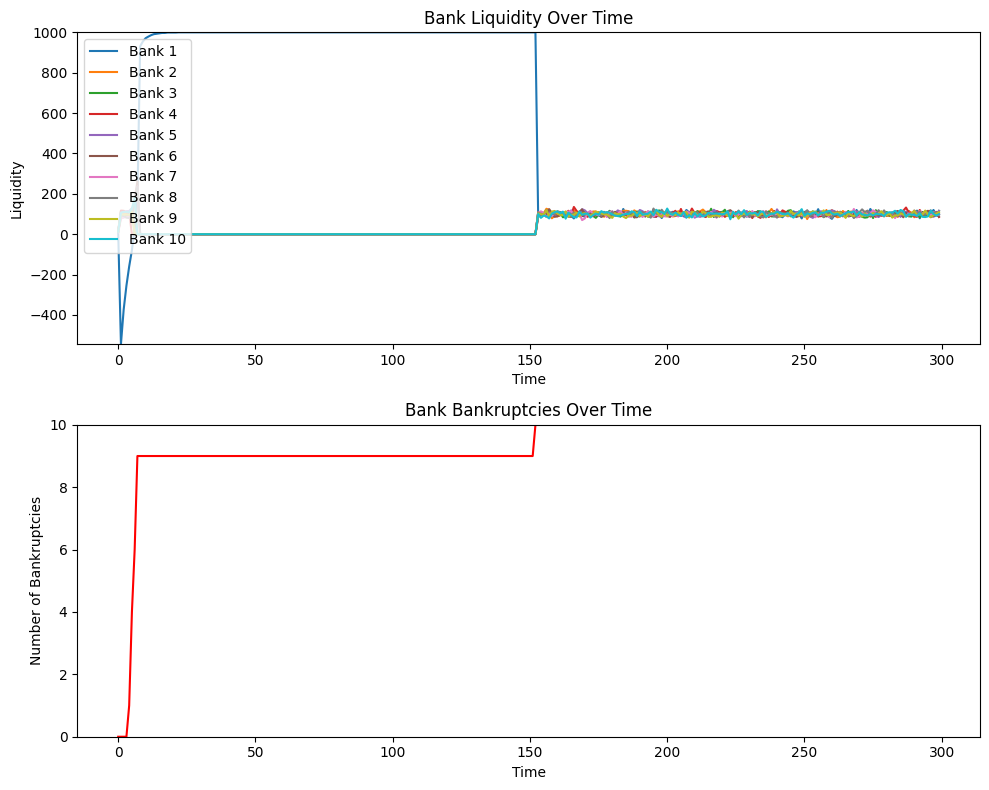

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = 300
n_banks = 10
n_households = 1000
n_borrowers = 2000
loan_periods = 1
equity = 40
interest = 0.0125
CAR = 0.08
MRR = 0.12
depo_margin = 0.1
loan_margin = 0.9
recovery_rate = 0.02  # Reduced recovery rate
withdrawal_prob_min = 0.01
withdrawal_prob_max = 0.1
default_prob_min = 0.01  # Increased minimum default probability
default_prob_max = 0.5  # Increased maximum default probability
reserve_fire_sell = 0.8
bankruptcy_fire_sell = 0.5
safety_effect = 0.04
operational_cost = 0.02  # Increased operational cost per unit of deposit

# Interest rate shock parameters
interest_shock_TF = True
p_change_interest = 5
interest_delta = 0.005

def concentration_spread(x):
    return 0.15 * x ** 2

def risk_weight(x):
    return 0.5 + 5 * x

# Agent matrices
households = {
    "depo_value": np.ones((t, n_households)),
    "which_bank": np.zeros((t, n_households), dtype=int),
    "withdrawal_prob": np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, (t, n_households))
}
households["which_bank"][0, :] = np.random.choice(n_banks, n_households)

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers), dtype=int),
    "pd": np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers)),
    "recovery_rate": np.full((t, n_borrowers), recovery_rate),
    "risk_weight": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "loan_end": np.random.choice(loan_periods, n_borrowers)
}
borrowers["which_bank"][0, :] = np.random.choice(n_banks, n_borrowers)

banks = {
    "equity": np.full((t, n_banks), equity),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks), dtype=bool),
    "undercapitalized": np.zeros((t, n_banks), dtype=bool),
    "liquidity_assistance": np.zeros((t, n_banks))
}

# Initial values
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin + 1) * interest) - borrowers["pd"][0, q] * recovery_rate) / (1 - borrowers["pd"][0, q])

for w in range(n_banks):
    banks["sum_deposits"][0, w] = np.sum(households["depo_value"][0, households["which_bank"][0, :] == w])
    RW_assets = borrowers["risk_weight"][0, borrowers["which_bank"][0, :] == w]
    potential_loans = min(
        int(banks["sum_deposits"][0, w] * (1 - MRR)),
        int((banks["equity"][0, w] / CAR) / np.mean(RW_assets))
    )
    borrower_indices = np.where(borrowers["which_bank"][0, :] == w)[0]
    borrowers["loan_value"][0, borrower_indices[:potential_loans]] = 1
    banks["loan_portfolio"][0, w] = np.sum(borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w])
    banks["risk_weighted_assets"][0, w] = np.sum(
        borrowers["risk_weight"][0, borrowers["which_bank"][0, :] == w] * borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w]
    )
    banks["exp_loss_provision"][0, w] = np.sum(
        borrowers["pd"][0, borrowers["which_bank"][0, :] == w] * borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w] * (1 - recovery_rate)
    )
    banks["reserves"][0, w] = banks["sum_deposits"][0, w] - banks["loan_portfolio"][0, w]

# Interest rate shock
if interest_shock_TF:
    interest = np.concatenate([
        np.full(p_change_interest - 1, interest),
        np.full(t - p_change_interest + 1, interest + interest_delta)
    ])

# Simulation
for p in range(1, t):
    for u in range(n_households):
        if np.random.rand() < households["withdrawal_prob"][p - 1, u]:
            available_banks = np.where(banks["bankruptcy"][p - 1, :] == 0)[0]
            if len(available_banks) == 0:
                households["which_bank"][p, u] = np.random.choice(n_banks)
            else:
                households["which_bank"][p, u] = np.random.choice(available_banks)
        else:
            households["which_bank"][p, u] = households["which_bank"][p - 1, u]

    for b in range(n_banks):
        banks["sum_deposits"][p, b] = np.sum(households["depo_value"][p, households["which_bank"][p, :] == b])

    borrowers["loan_value"][p, :] = borrowers["loan_value"][p - 1, :]
    for i in np.where(borrowers["loan_value"][p, :] == 1)[0]:
        if np.random.rand() < borrowers["pd"][p, i]:
            borrowers["loan_value"][p, i] = 0

    for r in range(n_banks):
        banks["loan_portfolio"][p, r] = np.sum(borrowers["loan_value"][p, borrowers["which_bank"][p, :] == r])

    for a in range(n_banks):
        banks["exp_loss_provision"][p, a] = np.sum(
            borrowers["pd"][p, borrowers["which_bank"][p, :] == a] * borrowers["loan_value"][p, borrowers["which_bank"][p, :] == a] * (1 - recovery_rate)
        )

    for l in range(n_borrowers):
        borrowers["cost_capital"][p, l] = (1 + ((loan_margin + 1) * interest[p]) - borrowers["pd"][p, l] * recovery_rate) / (1 - borrowers["pd"][p, l])

    for y in range(n_banks):
        banks["revenue"][p, y] = np.sum(
            borrowers["cost_capital"][p, borrowers["which_bank"][p, :] == y] * borrowers["loan_value"][p, borrowers["which_bank"][p, :] == y]
        ) + banks["reserves"][p - 1, y] * interest[p - 1]
        banks["cost"][p, y] = np.sum(
            households["depo_value"][p - 1, households["which_bank"][p, :] == y] * interest[p] * (1 + depo_margin)
        ) + operational_cost * banks["sum_deposits"][p - 1, y]
        banks["income"][p, y] = banks["revenue"][p, y] - banks["cost"][p, y] - (banks["exp_loss_provision"][p - 1, y] - banks["exp_loss_provision"][p, y])
        banks["equity"][p, y] = banks["equity"][p - 1, y] + banks["income"][p, y]
        banks["reserves"][p, y] = banks["sum_deposits"][p, y] - banks["loan_portfolio"][p, y]

    for k in np.where(banks["equity"][p, :] <= 0)[0]:
        banks["bankruptcy"][p, k] = True
        for s in np.where(households["which_bank"][p, :] == k)[0]:
            available_banks = np.where(banks["bankruptcy"][p, :] == False)[0]
            if len(available_banks) == 0:
                households["which_bank"][p, s] = np.random.choice(n_banks)
            else:
                households["which_bank"][p, s] = np.random.choice(available_banks)

# Results Visualization
bank_liquidity = banks["reserves"]
bank_bankruptcy = banks["bankruptcy"]

# Increase plot margins and save to file
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for i in range(n_banks):
    plt.plot(bank_liquidity[:, i], label=f'Bank {i+1}')
plt.ylim(bank_liquidity.min(), bank_liquidity.max())
plt.ylabel('Liquidity')
plt.xlabel('Time')
plt.title('Bank Liquidity Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.sum(bank_bankruptcy, axis=1), color='red')
plt.ylim(0, n_banks)
plt.ylabel('Number of Bankruptcies')
plt.xlabel('Time')
plt.title('Bank Bankruptcies Over Time')
plt.tight_layout()
plt.savefig('bank_simulation.png')

print("Simulation completed!")


In [9]:
banks['bankruptcy']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [12]:
banks['liquidity']

KeyError: 'liquidity'